In [523]:
import posenet
import torch
import cv2
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
from torchvision import transforms
import os

In [524]:

model = posenet.MobileNetV1(50)
model = model.cuda()

# 加载预训练权重
# pretrained_dict = torch.load('_models\mobilenet_v1_101.pth')
# # model_dict = model.state_dict()
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# model_dict.update(pretrained_dict)

In [525]:
# # 初始化缺少的权重
# for name, param in model.named_parameters():
#     if 'new1' in name or 'new2' in name or 'new3' in name:
#         if 'weight' in name:
#             init.kaiming_normal_(param)
#         elif 'bias' in name:
#             init.constant_(param, 0)

In [526]:
# for name, param in model.named_parameters():
#     if 'new' not in name:
#         param.requires_grad = False

In [527]:
# for name, param in model.named_parameters():
#     if 'new' in name:
#         print(name)

### 验证输入图像预处理

In [528]:
orimodel = posenet.load_model(101)
orimodel = orimodel.cuda()

In [529]:
import pandas as pd
import ast
train=pd.read_csv('data\labels.csv')
train.iloc[:, 2:] = train.iloc[:, 2:].map(lambda x: [float(i) for i in ast.literal_eval(x)])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            1780 non-null   object
 1   num_keypoints   1780 non-null   int64 
 2   nose            1780 non-null   object
 3   left_eye        1780 non-null   object
 4   right_eye       1780 non-null   object
 5   left_ear        1780 non-null   object
 6   right_ear       1780 non-null   object
 7   left_shoulder   1780 non-null   object
 8   right_shoulder  1780 non-null   object
 9   left_elbow      1780 non-null   object
 10  right_elbow     1780 non-null   object
 11  left_wrist      1780 non-null   object
 12  right_wrist     1780 non-null   object
 13  left_hip        1780 non-null   object
 14  right_hip       1780 non-null   object
 15  left_knee       1780 non-null   object
 16  right_knee      1780 non-null   object
 17  left_ankle      1780 non-null   object
 18  right_an

In [530]:

import numpy as np
# 保证其宽高是步长的整数倍+1
def valid_resolution(width, height, output_stride=16):
    target_width = (int(width) // output_stride) * output_stride + 1
    target_height = (int(height) // output_stride) * output_stride + 1
    return target_width, target_height

def process_input(source_img, scale_factor=1.0, output_stride=16):
    # 根据步长初步调整输入图像的大小
    target_width, target_height = valid_resolution(source_img.shape[1] * scale_factor, source_img.shape[0] * scale_factor,output_stride=output_stride)
    # 尺寸调整
    scale = np.array([source_img.shape[0] / target_height, source_img.shape[1] / target_width])
    input_img = cv2.resize(source_img, (target_width, target_height), interpolation=cv2.INTER_LINEAR) #使用双线性插值
    # RGB格式转换 并使用f32
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB).astype(np.float32)    
    # 归一化和格式转换
    input_img = input_img * (2.0 / 255.0) - 1.0
    input_img = input_img.transpose((2, 0, 1)).reshape(1, 3, target_height, target_width)
    return input_img ,source_img, scale

In [531]:

def read_imgfile(path, scale_factor=1.0, output_stride=16):
    img = cv2.imread(path)
    return process_input(img, scale_factor, output_stride)

def get_pic_path(name):
    return 'data\\train\\'+name

path=get_pic_path(train['name'][9])
processed_image,source_image,scale= read_imgfile(path)
print(processed_image.shape)
print(scale)

(1, 3, 289, 465)
[1.03114187 1.00645161]


In [532]:
from posenet.decode_multi import decode_multiple_poses
from test import process_single


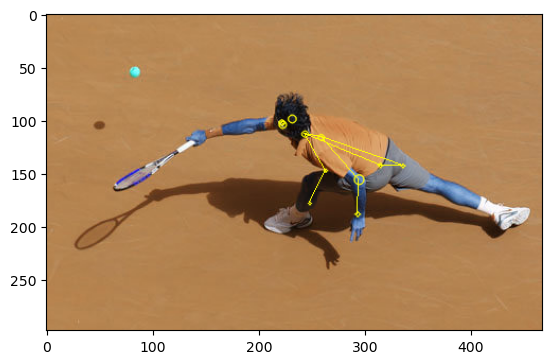

In [533]:
demo_image = process_single(orimodel,source_image,processed_image)
plt.imshow(demo_image)

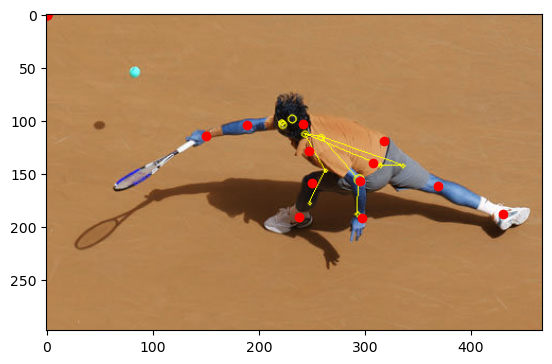

In [534]:
#name,num_keypoints,nose,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle
#000000490242.jpg,16,"[151, 105]","[161, 95]","[137, 87]","[0, 0]","[98, 87]","[109, 166]","[89, 180]","[173, 226]","[97, 308]","[249, 236]","[175, 350]","[113, 360]","[134, 371]","[132, 488]","[148, 496]","[128, 552]","[145, 619]"
#000000482775.jpg,3,"[77, 50]","[90, 34]","[60, 33]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
import ast

for i in range(17):
    keypoint = train.iloc[9, 2+i]
    plt.scatter(keypoint[0], keypoint[1], c='r')
plt.imshow(demo_image)
plt.show()

### TRAIN

In [535]:
label1 = train.iloc[9,2:].values
print(label1)

[list([0.0, 0.0]) list([0.0, 0.0]) list([0.0, 0.0]) list([0.0, 0.0])
 list([0.0, 0.0]) list([247.0, 128.0]) list([242.0, 103.0])
 list([295.0, 157.0]) list([189.0, 104.0]) list([297.0, 192.0])
 list([150.0, 114.0]) list([308.0, 140.0]) list([318.0, 119.0])
 list([250.0, 159.0]) list([369.0, 161.0]) list([238.0, 191.0])
 list([430.0, 188.0])]


In [536]:
with torch.no_grad():
    inputs = torch.Tensor(processed_image).cuda()
    heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = orimodel(inputs)


    pose_scores, keypoint_scores, keypoint_coords, pose_offsets = posenet.decode_multi.decode_multiple_poses(
        heatmaps_result.squeeze(0),
        offsets_result.squeeze(0),
        displacement_fwd_result.squeeze(0),
        displacement_bwd_result.squeeze(0),
        output_stride=16,
        max_pose_detections=10,
        min_pose_score=0.0)



In [537]:
print(keypoint_coords)

[[[101.98146152 222.14994359]
  [104.04931927 222.94946694]
  [101.89385796 223.29485667]
  [ 98.47646999 231.87065983]
  [102.20555496 228.02278376]
  [115.86327267 259.21620846]
  [112.71841592 243.96767139]
  [155.75902891 294.99258518]
  [147.18903565 263.46109533]
  [188.29324198 293.62774801]
  [177.98698056 248.40769577]
  [142.6278553  336.40684849]
  [142.20207405 315.04131269]
  [161.82469654 373.51381207]
  [170.32715416 336.12862913]
  [176.20870209 413.37993431]
  [181.0363245  387.42802238]]

 [[101.79826927 223.3598423 ]
  [104.04931927 222.94946694]
  [101.89385796 223.29485667]
  [ 98.47646999 231.87065983]
  [102.20555496 228.02278376]
  [115.27716827 260.97226906]
  [107.41878796 229.33129883]
  [158.7635355  292.09169865]
  [101.4370327  188.04481459]
  [188.21357536 289.44486701]
  [113.54268014 152.50342655]
  [142.6278553  336.40684849]
  [142.5855279  303.76163159]
  [161.82469654 373.51381207]
  [166.8522377  298.79621363]
  [176.20870209 413.37993431]
  [191.8

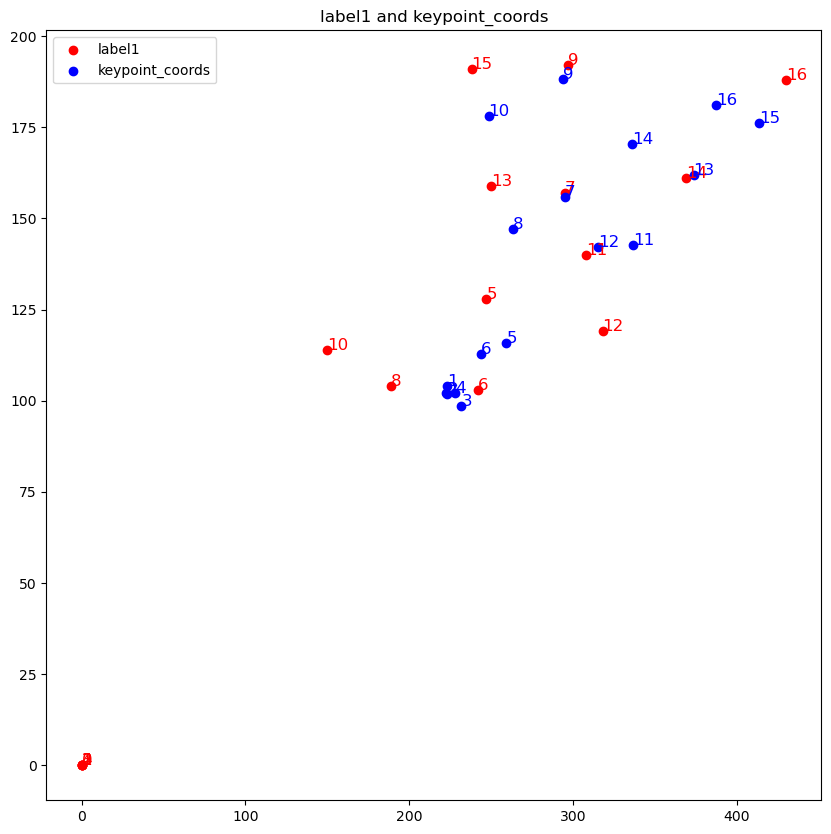

In [538]:
plt.figure(figsize=(10, 10))
labelx = []
labely = []
for i in range(len(label1)):
    labelx.append(label1[i][0])
    labely.append(label1[i][1])
plt.scatter(labelx, labely, c='r', label='label1')
plt.scatter(keypoint_coords[0][:, 1], keypoint_coords[0][:, 0], c='b', label='keypoint_coords')
for i in range(len(label1)):
    plt.text(labelx[i], labely[i], str(i), color='red', fontsize=12)

# 为keypoint_coords中的每对坐标标注序号
for i in range(keypoint_coords.shape[1]):
    x = keypoint_coords[0][i, 1].item()
    y = keypoint_coords[0][i, 0].item()
    plt.text(x, y, str(i), color='blue', fontsize=12)

plt.legend()
plt.title('label1 and keypoint_coords')
plt.show()

In [539]:
print(heatmaps_result.shape)

torch.Size([1, 17, 19, 30])


0.70933884


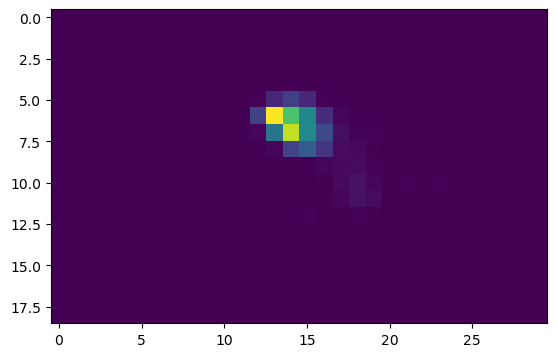

In [540]:
plt.imshow(heatmaps_result[0, 0].cpu().numpy())
print(max(heatmaps_result[0, 0].cpu().numpy().flatten()))

torch.Size([1, 34, 19, 30])


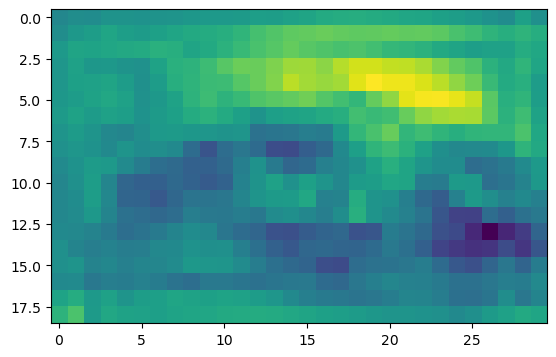

In [541]:
print(offsets_result.shape)
plt.imshow(offsets_result[0, 0].cpu().numpy())

torch.Size([1, 17])
tensor([[193, 194, 224, 195, 194, 226, 225, 318, 192, 356, 190, 260, 289, 323,
         349, 374, 374]], device='cuda:0')
最大值： tensor([[0.7093, 0.6620, 0.3298, 0.7597, 0.1627, 0.8124, 0.8417, 0.8942, 0.8499,
         0.6581, 0.7799, 0.6291, 0.6948, 0.3061, 0.5058, 0.4592, 0.5059]],
       device='cuda:0')
最大值索引 (y, x)： tensor([[ 96,  96, 112,  96,  96, 112, 112, 160,  96, 176,  96, 128, 144, 160,
         176, 192, 192]], device='cuda:0') tensor([[208, 224, 224, 240, 224, 256, 240, 288, 192, 416, 160, 320, 304, 368,
         304, 224, 224]], device='cuda:0')


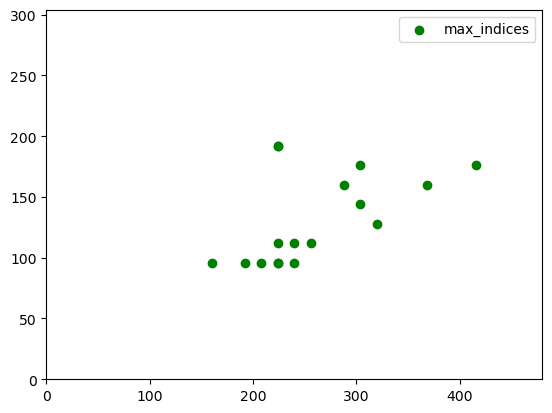

In [542]:

max_vals, max_indices = torch.max(heatmaps_result.view(1, 17, -1), dim=2)
print(max_indices.size())   
print(max_indices)
# 将一维索引转换为二维坐标 (y, x)
h, w = heatmaps_result.shape[2], heatmaps_result.shape[3]
max_y = max_indices // w *16
max_x = max_indices % w  *16

# 打印结果
print("最大值：", max_vals)
print("最大值索引 (y, x)：", max_y, max_x)
plt.scatter(max_x.cpu(), max_y.cpu(), c='g', label='max_indices')
plt.legend()
plt.xlim(0, w * 16)
plt.ylim(0, h * 16)
plt.show()

247.0 128.0
(19, 30)
1.0


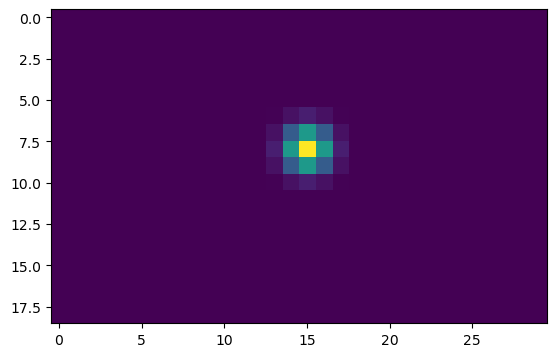

In [543]:
def points_to_heatmap(keypoint_x, keypoint_y, heatmap_size, kernel_size=9):

    if keypoint_x == 0 and keypoint_y == 0:
        return np.zeros(heatmap_size)
    heatmap = np.zeros(heatmap_size)

    # Compute a Gaussian kernel centered at the keypoint
    kernel_std = kernel_size / 10
    kernel = cv2.getGaussianKernel(kernel_size, kernel_std)
    kernel = np.outer(kernel, kernel.transpose())

    xmin = max(int(keypoint_x - kernel_size//2), 0)
    xmax = min(int(keypoint_x + kernel_size//2 + 1), heatmap_size[1])
    ymin = max(int(keypoint_y - kernel_size//2), 0)
    ymax = min(int(keypoint_y + kernel_size//2 + 1), heatmap_size[0])

    kernel_xmin = max(0, kernel_size//2 - int(keypoint_x) - xmin)
    kernel_xmax = min(kernel_size, kernel_size//2 + xmax - int(keypoint_x))
    kernel_ymin = max(0, kernel_size//2 - int(keypoint_y) + ymin)
    kernel_ymax = min(kernel_size, kernel_size//2 + ymax - int(keypoint_y))

    heatmap[ymin:ymax, xmin:xmax] += kernel[kernel_ymin:kernel_ymax, kernel_xmin:kernel_xmax]
    
    # keypoint_x = int(keypoint_x)
    # keypoint_y = int(keypoint_y)
    # heatmap[keypoint_y,keypoint_x] +=1

    # Normalize the heatmap values
    heatmap /= np.max(heatmap)
    return heatmap
print(labelx[5],labely[5])
target = points_to_heatmap(labelx[5]//16,labely[5]//16,heatmaps_result.shape[2:])
print(target.shape)
print(max(target.flatten()))
plt.imshow(target)
plt.show()


(1, 17, 19, 30)


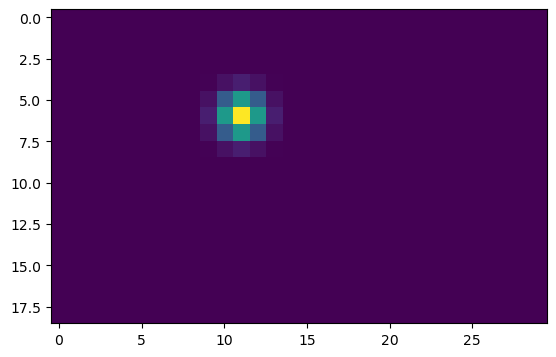

In [544]:
def get_heatmap(label,heatmap_size,kernel_size):
    heatmap = np.zeros((17, heatmap_size[0], heatmap_size[1]))
    for i in range(17):
        heatmap[i] = points_to_heatmap(label[i][0]//16,label[i][1]//16,heatmap_size,kernel_size=kernel_size)
    heatmap = heatmap.reshape(1, 17, heatmap_size[0], heatmap_size[1])
    return heatmap
map1=get_heatmap(label1,heatmaps_result.shape[2:],9)
print(map1.shape)
# print(map1[0][8])
plt.imshow(map1[0][8])
plt.show()

In [545]:
def get_corner_panish(heatmaps_result):
    h,w = heatmaps_result.shape[2],heatmaps_result.shape[3]
    loss = 0
    for i in range(17):
        loss += torch.mean(heatmaps_result[0, i, :2, :])  # Top edge
        loss += torch.mean(heatmaps_result[0, i, -2:, :])  # Bottom edge
        loss += torch.mean(heatmaps_result[0, i, :, :2])  # Left edge
        loss += torch.mean(heatmaps_result[0, i, :, -2:])  # Right edge
    return loss
corner = get_corner_panish(heatmaps_result)
print(corner)

tensor(0.0065, device='cuda:0')


In [546]:

KERNEL_SIZE = 5

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
# 训练循环
num_epochs = 5
print(len(train))
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in range(len(train)):
        if i % 400 == 0:
            print(f'process pic:{i}')
        
        # 获取输入图像和关键点
        path = get_pic_path(train['name'][i])
        processed_image, source_image, scale = read_imgfile(path)
        inputs = torch.Tensor(processed_image).cuda()
        label = train.iloc[i, 2:].values

        # 前向传播
        optimizer.zero_grad()  
        heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = model(inputs)

        # 构建标签的heatmap
        label_map=get_heatmap(label,heatmaps_result.shape[2:],kernel_size=KERNEL_SIZE)

        # 损失和梯度
        # loss= nn.MSELoss()(heatmaps_result, torch.Tensor(label_map).cuda())

        loss = nn.BCEWithLogitsLoss()(heatmaps_result, torch.Tensor(label_map).cuda())+get_corner_panish(heatmaps_result)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train):.4f}')

1780
process pic:0
process pic:400
process pic:800
process pic:1200
process pic:1600
Epoch [1/5], Loss: 0.7208
process pic:0
process pic:400
process pic:800
process pic:1200
process pic:1600
Epoch [2/5], Loss: 0.6931
process pic:0
process pic:400
process pic:800
process pic:1200
process pic:1600
Epoch [3/5], Loss: 0.6931
process pic:0
process pic:400
process pic:800
process pic:1200
process pic:1600
Epoch [4/5], Loss: 0.6931
process pic:0
process pic:400
process pic:800
process pic:1200
process pic:1600
Epoch [5/5], Loss: 0.6931


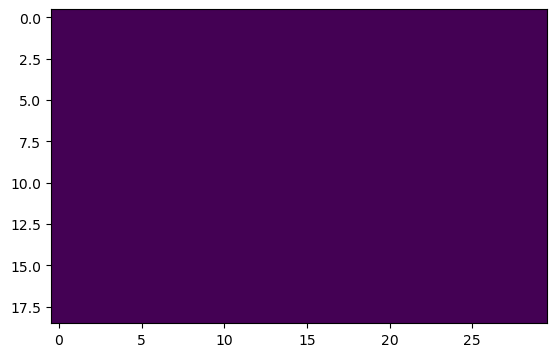

In [550]:
path=get_pic_path(train['name'][9])
processed_image,source_image,scale= read_imgfile(path)
with torch.no_grad():
    inputs = torch.Tensor(processed_image).cuda()
    heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = model(inputs)


    pose_scores, keypoint_scores, keypoint_coords, pose_offsets = posenet.decode_multi.decode_multiple_poses(
        heatmaps_result.squeeze(0),
        offsets_result.squeeze(0),
        displacement_fwd_result.squeeze(0),
        displacement_bwd_result.squeeze(0),
        output_stride=16,
        max_pose_detections=10,
        min_pose_score=0.0)
plt.imshow(heatmaps_result[0][8].cpu().numpy())